In [94]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [95]:
train_path = '/content/sample_data/mnist_train_small.csv'
test_path = '/content/sample_data/mnist_test.csv'

In [96]:
class Data(Dataset):
  def __init__(self, path, resize=1):
    super().__init__()
    self.path = path
    if resize == 1 or 2 or 4:
      self.resize = resize
      self.dim = dim = 28 // self.resize
    else:
      raise Exception('resize must be either 1, 2 or 4')
    self.samples = self.get_samples()

  def get_samples(self):
    samples = []
    data = pd.read_csv(self.path).to_numpy()
    if self.resize > 1:
      bs = len(data)
      y = data[:,0]
      X = data[:,1:].reshape((bs,28,28))
      A = np.zeros((self.dim,28))
      for i in range(self.dim):
        for j in range(self.resize):
          A[i][i*self.resize + j] = 1
      X = A @ X @ A.T
      X = (X // self.resize).astype(int)
      X = X.reshape((bs, self.dim ** 2))
      data = np.concatenate((np.expand_dims(y, axis=1),X), axis=1)
    
    for i in range(data.shape[0]):
      y = torch.tensor(data[i][0])
      x = torch.tensor(data[i][1:] / 255).float()
      samples.append((x,y))
    return samples
  
  def __len__(self):
    return len(self.samples)
  
  def __getitem__(self, idx):
    return self.samples[idx]
  
  def view_sample(self, d=3):
    fig = plt.figure(figsize=(5,5))
    rows,cols = d,d
    for i in range(1,rows*cols + 1):
      idx = np.random.randint(len(self))
      x,y = self[idx]
      label = y.item()
      img = np.reshape(x,(self.dim,self.dim))
      fig.add_subplot(rows,cols,i)
      plt.axis('off')
      plt.title(label)
      plt.imshow(img,cmap="gray")
    plt.plot()

In [97]:
bs = 64

In [98]:
train_data = Data(train_path)
test_data = Data(test_path)
train_dataloader = DataLoader(train_data,bs,shuffle=True)
test_dataloader = DataLoader(test_data,bs,shuffle=True)

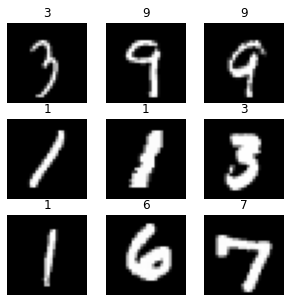

In [99]:
train_data.view_sample()

In [100]:
class Model(nn.Module):

  def __init__(self):
    super().__init__()
    self.model = nn.Sequential(
        nn.Linear(28*28,100),
        nn.BatchNorm1d(100),
        nn.LeakyReLU(),
        nn.Linear(100,50),
        nn.BatchNorm1d(50),
        nn.LeakyReLU(), 
        nn.Linear(50,10),
        nn.BatchNorm1d(10),
        nn.LeakyReLU(),          
    )

  def forward(self,x):
    return self.model(x)

In [9]:
def train_model(dataloader):
    losses = []
    iterator = iter(dataloader)
    for batch in range(len(dataloader)):
      x,y = next(iterator)
      optimiser.zero_grad()
      out = model(x)
      loss = loss_func(out,y)
      loss.backward()
      optimiser.step()
      losses.append(loss.detach().numpy())
    return losses
  
def test_model(dataloader,dataset):
  count = 0
  iterator = iter(dataloader)
  for batch in range(len(dataloader)):
    x,y = next(iterator)
    out = model(x).detach()
    count += torch.where(torch.argmax(out,axis=1) == y, 1, 0).detach().numpy().sum()
  accuracy = 100 * count / len(dataset)
  return accuracy

def train(train_dataloader, test_dataloader, test_dataset, epochs=1):
  losses = []
  for epoch in range(epochs):
    epoch_losses = train_model(train_dataloader)
    losses = np.concatenate((losses, epoch_losses))
    accuracy = test_model(test_dataloader, test_dataset)
    print(f'[Epoch {epoch+1}/{epochs}] Accuracy: {accuracy}%')
  plt.plot(losses)


In [101]:
model = Model()
loss_func = nn.CrossEntropyLoss()
lr = 0.01
optimiser = torch.optim.SGD(model.parameters(),lr=lr)

In [102]:
model

Model(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=100, out_features=50, bias=True)
    (4): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=50, out_features=10, bias=True)
    (7): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
  )
)

[Epoch 1/5] Accuracy: 91.12911291129113%
[Epoch 2/5] Accuracy: 92.83928392839285%
[Epoch 3/5] Accuracy: 93.91939193919391%
[Epoch 4/5] Accuracy: 94.1994199419942%
[Epoch 5/5] Accuracy: 94.75947594759477%


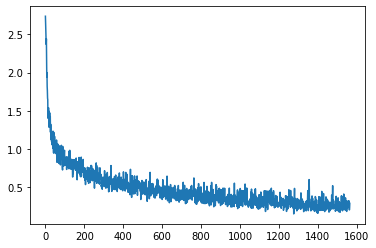

In [93]:
train(train_dataloader, test_dataloader, test_data ,epochs=5)